References:

[1] https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import datasets

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

# Part I. Synthetic data

In [3]:
np.random.seed(42)

In [4]:
N = 7   # num of examples
D = 4   # feature dimension
X = np.random.normal(size=(N, D))

# standardize X
mu = X.mean(axis=0, keepdims=True)
std = X.std(axis=0, keepdims=True)
X = (X - mu) / std

In [5]:
X

array([[ 0.6636078 ,  0.11092274,  0.88283497,  1.64765529],
       [-0.29721033, -0.0183429 ,  1.77028729,  0.91286294],
       [-0.60656967,  1.02888199, -0.17570298, -0.28635049],
       [ 0.32870412, -2.28234114, -1.37751945, -0.38024987],
       [-1.32088106,  0.72104669, -0.5992743 , -1.20686369],
       [ 1.93739533, -0.00707018,  0.33012298, -1.21896556],
       [-0.70504619,  0.44690281, -0.83074851,  0.53191139]])

## 1. Singular Value Decomposition (SVD)

### use economy-sized SVD

In [6]:
U, s, Vt = np.linalg.svd(X, full_matrices=False, compute_uv=True)
V = Vt.T
S = np.diag(s)

In [7]:
print(f'U shape: {U.shape}')
print(f'S shape: {S.shape}')
print(f'V shape: {V.shape}')

U shape: (7, 4)
S shape: (4, 4)
V shape: (4, 4)


### Check that $X = U S V^T$

In [8]:
np.allclose(X, U.dot(S).dot(V.T))

True

## 2. Principal Component Analysis (PCA)

First, constrcut the covariance matrix. Also check with manual construction

In [9]:
C = np.cov(X, rowvar=False) 

In [10]:
np.allclose(C, (1./(N-1)) * X.T.dot(X))

True

In [11]:
eig_vals, eig_vecs = np.linalg.eig(C)

In [12]:
sorted_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sorted_idx]
eig_vecs = eig_vecs[:, sorted_idx]

## 3. SVD vs PCA

### 1) Check that the left singular vectors (the column vectors in $V$) are the same as the eigenvectors of the Covariance matrix $\Sigma = \frac{1}{N-1} X^T X $

In [13]:
np.allclose(eig_vecs, V) or np.allclose(eig_vecs, -V)

True

### 2) Check that the eigenvalues of the covariance matrix $\Sigma$, $\lambda_i$'s, are the scaled singular values. Specifically, $\lambda_i = \frac{1}{N-1} \sigma_i^2$

In [14]:
np.allclose(eig_vals, np.power(s, 2)/(N-1))

True

### 3) In PCA, we choose $L$ basis vectors $\{w_j \in \mathbb{R}^D, j=1, \dots,L  \}$ to approximate the original data matrix $X$. We can pack the basis vectors in a matrix $\hat{W} = \big( w_1, w_2, \dots, w_L\big)$. 

$\hat{x}^{(i)} = \hat{W} z^{(i)}$, where $z^{(i)} \in \mathbb{R}^L$ is the loading in the space spanned by $\hat{W}$. 

Or in matrix form, $\hat{X}^T = \hat{W} Z^T$

### Vetify that $Z = \hat{X} \hat{W} = U_{:,1:L} S_{1:L, 1:L}$

In [15]:
np.allclose(
    X.dot(eig_vecs), 
    U.dot(S)
) or \
np.allclose(
    X.dot(eig_vecs), 
    -U.dot(S)
)

True

In [16]:
L = 3

In [17]:
np.allclose(
    X.dot(eig_vecs[:, :L]), 
    U[:,:L].dot(S[:L,:L]) 
) or \
np.allclose(
    X.dot(eig_vecs[:, :L]), 
    -U[:,:L].dot(S[:L,:L])
)


True

## 4. Manual PCA vs scikit-learn's PCA

In [18]:
pca = PCA(n_components=L)
pca.fit(X)

PCA(n_components=3)

### 1) Check eigenvectors

In [19]:
np.allclose(pca.components_, eig_vecs[:, :L].T) or np.allclose(pca.components_, -eig_vecs[:, :L].T) 


True

### 2) Check eigenvalues

In [20]:
np.allclose(pca.explained_variance_, eig_vals[:L])

True

### 3) Check loading $Z$

In [21]:
Z = X.dot(eig_vecs[:, :L])

In [22]:
np.allclose(pca.transform(X), Z) or np.allclose(pca.transform(X), -Z)

True

### 4) Check reconstructed $X$, $\hat{X} = Z \hat{W}^T$

In [23]:
X_hat = Z.dot(eig_vecs[:,:L].T)

In [24]:
np.allclose(pca.inverse_transform(Z), X_hat) or np.allclose(pca.inverse_transform(Z), -X_hat)


True

# Part II. Iris data

In [25]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

In [26]:
pca_iris = PCA(n_components=2) 
Z_iris = pca_iris.fit_transform(X_iris)

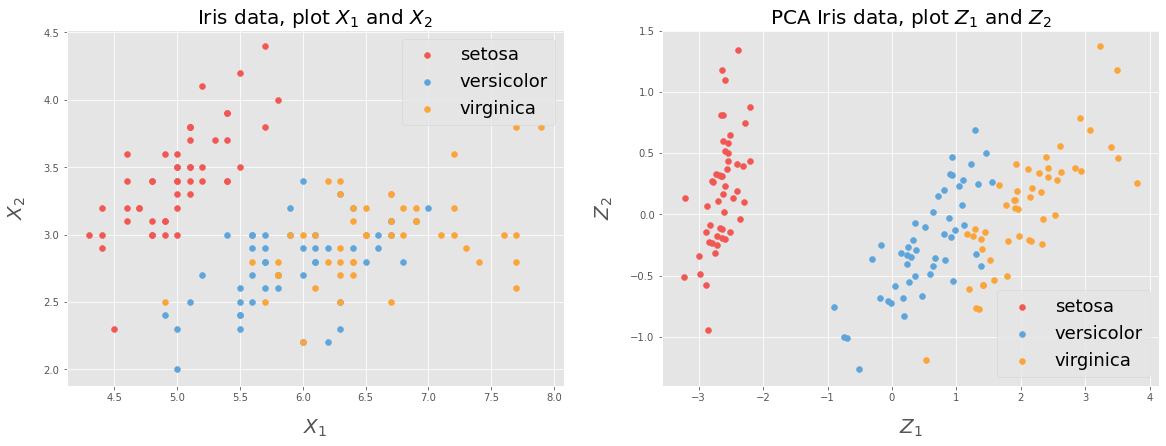

In [27]:
red = '#F15854'
blue = '#5DA5DA'
orange = '#FAA43A'
colors = np.array([red, blue, orange])

fontsize = 20

plt.close('all')
fig = plt.figure(figsize=(16, 6))
gs = matplotlib.gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
for cls, color in enumerate(colors):
    indices = np.arange(len(X_iris))[y_iris == cls]
    ax.scatter(
        X_iris[indices, 0],
        X_iris[indices, 1],
        c=color,
        label=iris.target_names[cls]
    )
ax.set_xlabel(r'$X_1$', fontsize=fontsize, labelpad=15)    
ax.set_ylabel(r'$X_2$', fontsize=fontsize, labelpad=15)    
ax.legend(loc='best', fontsize=fontsize*0.9)
ax.set_title(r'Iris data, plot $X_1$ and $X_2$', fontsize=fontsize)



ax = plt.subplot(gs[0, 1])
for cls, color in enumerate(colors):
    indices = np.arange(len(X_iris))[y_iris == cls]
    ax.scatter(
        Z_iris[indices, 0],
        Z_iris[indices, 1],
        c=color,
        label=iris.target_names[cls]
    )
ax.set_xlabel(r'$Z_1$', fontsize=fontsize, labelpad=15)    
ax.set_ylabel(r'$Z_2$', fontsize=fontsize, labelpad=15)        
ax.legend(loc='best', fontsize=fontsize*0.9)
ax.set_title(r'PCA Iris data, plot $Z_1$ and $Z_2$', fontsize=fontsize)

plt.tight_layout(pad=0, w_pad=3.0, h_pad=0)